# Visualising CNNs

### Introduction to Pretrained PyTorch models 
### Based on lecture by Dr. Antonin Vacheret


<hr style="border:2px solid gray">

## Index: <a id='index'></a>
1. [Pre-trained Legacy computer vision classifier models](#PTL)
1. [AlexNet Model](#ANM)
1. [Resnet 101](#101)
1. [Convolution](#LTA)
1. [Visualise CNN](#CNN)


<hr style="border:2px solid gray">
A quick run through some basics of pyTorch starting from a quick exploration of the models readily available

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import torch
import torch.nn as nn
torch.version.__version__

'2.0.1'

<hr style="border:2px solid gray">

## I. Pre-trained Legacy computer vision classifier models [^](#index)
<a id='PCL'></a>

In [66]:
from torchvision import models
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

This is the famous AlexNet [^](#index) <a id='ANM'></a> model that shaked the field of machine learning in 2012:
https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

Note: the lowercase models have fixed 

In [67]:
alexnet_function = models.AlexNet() # this is the "empty shell" of Alexnet
alexnet_trained = models.alexnet(pretrained=True) # fixed artchitecture already pretrained

/Users/jingchaoyi/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jingchaoyi/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


This one is **Resnet 101** [^](#index) <a id='101'></a> which stands for **residual network**. This one is the 101 layer version.
https://arxiv.org/abs/1512.03385
It has beaten several benchmark in 2015 and started the deep learning revolution. It is trained on imagenet with 1.2M images on 1000 categories.


In [68]:
resnet = models.resnet101(pretrained=True) # beware this is taking on average a few mins to download

/Users/jingchaoyi/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<hr style="border:2px solid gray">

## Convolution [^](#index)
<a id='LTA'></a>

*From homl...*

Convolutional neural networks (CNNs) emerged from the study of the brain’s visual cortex, and they have been used in image recognition since the 1980s. In the last few years, thanks to the increase in computational power, the amount of available training data for training deep nets, CNNs have man‐ aged to achieve superhuman performance on some complex visual tasks. They power image search services, self-driving cars, automatic video classification systems, and more. Moreover, CNNs are not restricted to visual perception: they are also successful at many other tasks, such as voice recognition or natural language processing (NLP); however, we will focus on visual applications for now.

In this chapter we will present where CNNs came from, what their building blocks look like, and how to implement them using TensorFlow and Keras. Then we will dis‐ cuss some of the best CNN architectures, and discuss other visual tasks, including object detection (classifying multiple objects in an image and placing bounding boxes around them) and semantic segmentation (classifying each pixel according to the class of the object it belongs to).

Let's take a look at a high def picture of a dog. You can replace this one with your prefered one.

In [69]:
from PIL import Image
img = Image.open("img/mydoge.jpg")

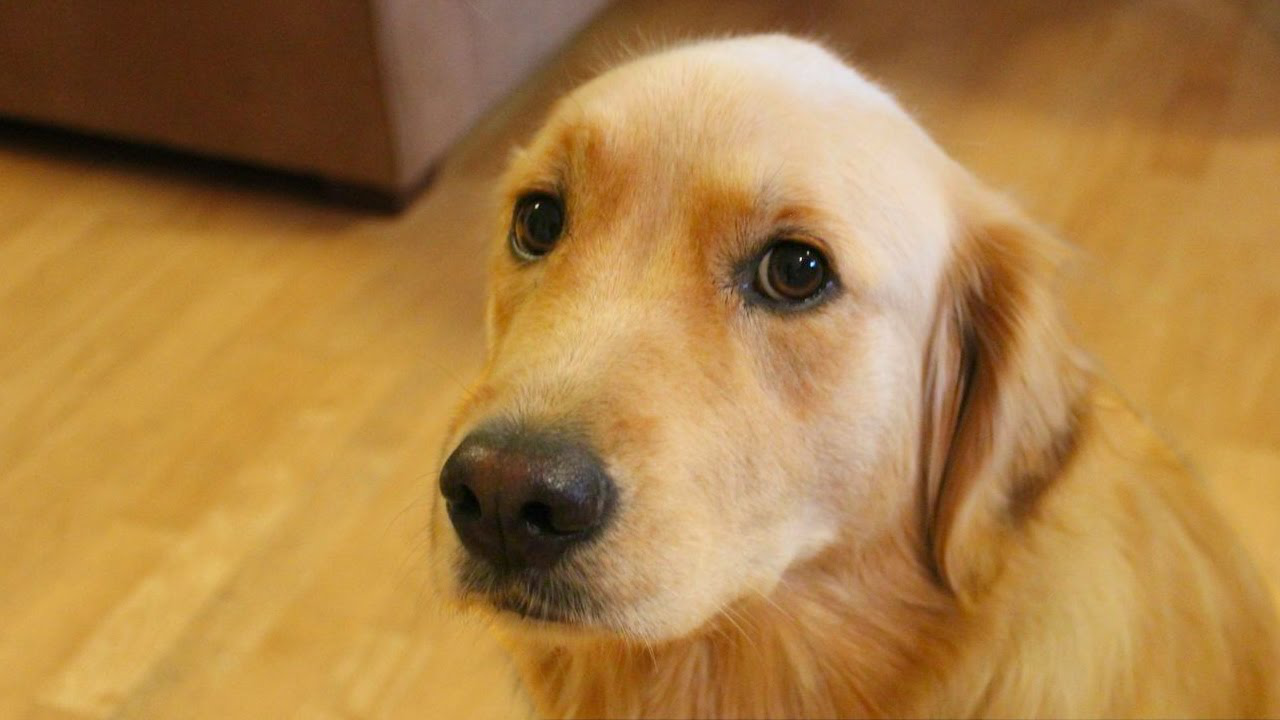

In [70]:
img

Importing high-definition image from img folder but now defining some **transformation** first (a very powerful feature of pytorch!) to preprocess the image and get the right input size for the network.

In [71]:
from torchvision import transforms
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )])

In [72]:
img_t = preprocess(img)

In [73]:
img_t

tensor([[[-0.6281, -0.6623, -0.6794,  ...,  0.0056, -0.0287, -0.0629],
         [-0.7137, -0.7137, -0.7137,  ...,  0.0398,  0.0227,  0.0056],
         [-0.7137, -0.7137, -0.7137,  ...,  0.0398,  0.0569,  0.0569],
         ...,
         [ 1.4440,  1.4269,  1.4783,  ...,  0.6049,  0.6221,  0.6906],
         [ 1.4269,  1.4440,  1.4783,  ...,  0.6906,  0.6734,  0.7077],
         [ 1.4612,  1.4783,  1.5125,  ...,  0.6906,  0.7248,  0.7419]],

        [[-1.2829, -1.2829, -1.2829,  ..., -0.6352, -0.6702, -0.7052],
         [-1.2654, -1.2479, -1.2654,  ..., -0.6176, -0.6527, -0.7052],
         [-1.2479, -1.2479, -1.2654,  ..., -0.6176, -0.6001, -0.6527],
         ...,
         [ 0.7829,  0.8004,  0.8704,  ..., -0.3025, -0.2675, -0.2150],
         [ 0.7654,  0.8354,  0.9055,  ..., -0.2150, -0.2150, -0.1625],
         [ 0.8004,  0.8529,  0.9230,  ..., -0.1800, -0.1275, -0.0749]],

        [[-1.4907, -1.4559, -1.4210,  ..., -1.0376, -1.0898, -1.1421],
         [-1.5081, -1.4559, -1.4210,  ..., -1

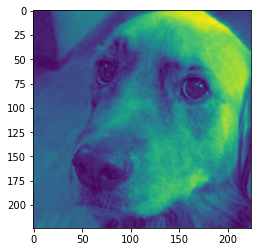

In [74]:
plt.imshow(img_t[2,:,:])

In [75]:
batch_t = torch.unsqueeze(img_t, 0)
batch_t

tensor([[[[-0.6281, -0.6623, -0.6794,  ...,  0.0056, -0.0287, -0.0629],
          [-0.7137, -0.7137, -0.7137,  ...,  0.0398,  0.0227,  0.0056],
          [-0.7137, -0.7137, -0.7137,  ...,  0.0398,  0.0569,  0.0569],
          ...,
          [ 1.4440,  1.4269,  1.4783,  ...,  0.6049,  0.6221,  0.6906],
          [ 1.4269,  1.4440,  1.4783,  ...,  0.6906,  0.6734,  0.7077],
          [ 1.4612,  1.4783,  1.5125,  ...,  0.6906,  0.7248,  0.7419]],

         [[-1.2829, -1.2829, -1.2829,  ..., -0.6352, -0.6702, -0.7052],
          [-1.2654, -1.2479, -1.2654,  ..., -0.6176, -0.6527, -0.7052],
          [-1.2479, -1.2479, -1.2654,  ..., -0.6176, -0.6001, -0.6527],
          ...,
          [ 0.7829,  0.8004,  0.8704,  ..., -0.3025, -0.2675, -0.2150],
          [ 0.7654,  0.8354,  0.9055,  ..., -0.2150, -0.2150, -0.1625],
          [ 0.8004,  0.8529,  0.9230,  ..., -0.1800, -0.1275, -0.0749]],

         [[-1.4907, -1.4559, -1.4210,  ..., -1.0376, -1.0898, -1.1421],
          [-1.5081, -1.4559, -

In [76]:
resnet.eval() # putting the model in inference mode (no training of the weights) 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [77]:
out = resnet(batch_t)
out

tensor([[-3.4803e+00, -1.6618e+00, -2.4515e+00, -3.2662e+00, -3.2466e+00,
         -1.3611e+00, -2.0465e+00, -2.5112e+00, -1.3043e+00, -2.8900e+00,
         -1.6862e+00, -1.3055e+00, -2.6129e+00, -2.9645e+00, -2.4300e+00,
         -2.8143e+00, -3.3019e+00, -7.9404e-01, -6.5183e-01, -1.2308e+00,
         -3.0193e+00, -3.9457e+00, -2.2675e+00, -1.0811e+00, -1.0232e+00,
         -1.0442e+00, -3.0918e+00, -2.4613e+00, -2.1964e+00, -3.2354e+00,
         -3.3013e+00, -1.8553e+00, -2.0921e+00, -2.1327e+00, -1.9102e+00,
         -3.2403e+00, -1.1396e+00, -1.0925e+00, -1.2186e+00, -9.3332e-01,
         -4.5093e-01, -1.5489e+00,  1.4161e+00,  1.0871e-01, -1.8442e+00,
         -1.4806e+00,  9.6227e-01, -9.9456e-01, -3.0060e+00, -2.7384e+00,
         -2.5798e+00, -2.0666e+00, -1.8022e+00, -1.9328e+00, -1.7726e+00,
         -1.3041e+00, -4.5848e-01, -2.0537e+00, -3.2804e+00, -5.0451e-01,
         -3.8174e-01, -1.1147e+00, -7.3998e-01, -1.4299e+00, -1.4883e+00,
         -2.1073e+00, -1.7373e+00, -4.

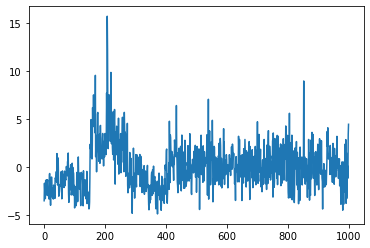

In [78]:
scores  = out.detach().numpy()
plt.plot(scores[0])
plt.show()

#### Now an operation involving a massive 44.5M parameters has just taken place !
This has produced a vector of a 1000 score, one for each label of the imagenet training set. Let's get the file that has the imagenet list of labels.

We need now to figure out what was the ranking for our dog picture. 

In [79]:
with open('data/data/imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]
labels

['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark',
 'electric ray, crampfish, numbfish, torpedo',
 'stingray',
 'cock',
 'hen',
 'ostrich, Struthio camelus',
 'brambling, Fringilla montifringilla',
 'goldfinch, Carduelis carduelis',
 'house finch, linnet, Carpodacus mexicanus',
 'junco, snowbird',
 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 'robin, American robin, Turdus migratorius',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel, dipper',
 'kite',
 'bald eagle, American eagle, Haliaeetus leucocephalus',
 'vulture',
 'great grey owl, great gray owl, Strix nebulosa',
 'European fire salamander, Salamandra salamandra',
 'common newt, Triturus vulgaris',
 'eft',
 'spotted salamander, Ambystoma maculatum',
 'axolotl, mud puppy, Ambystoma mexicanum',
 'bullfrog, Rana catesbeiana',
 'tree frog, tree-f

In [80]:
_, index = torch.max(out, 1) # this returns the value and index of the higest score
print(index)

tensor([207])


**Resnet** gives us a score, but what we are interested in is more something like a the probability of being of a certain category. We will use the **softmax function** for that (multi-class classifier). 

In [81]:
percentage = torch.nn.functional.softmax(out, dim=1)[0] # only one dimension, [0] is to return one value.
percentage

tensor([4.6218e-09, 2.8483e-08, 1.2930e-08, 5.7253e-09, 5.8386e-09, 3.8472e-08,
        1.9386e-08, 1.2181e-08, 4.0722e-08, 8.3405e-09, 2.7796e-08, 4.0673e-08,
        1.1003e-08, 7.7414e-09, 1.3212e-08, 8.9958e-09, 5.5247e-09, 6.7832e-08,
        7.8199e-08, 4.3827e-08, 7.3282e-09, 2.9019e-09, 1.5543e-08, 5.0903e-08,
        5.3939e-08, 5.2817e-08, 6.8163e-09, 1.2805e-08, 1.6688e-08, 5.9040e-09,
        5.5276e-09, 2.3471e-08, 1.8523e-08, 1.7785e-08, 2.2217e-08, 5.8754e-09,
        4.8012e-08, 5.0330e-08, 4.4368e-08, 5.9013e-08, 9.5598e-08, 3.1885e-08,
        6.1842e-07, 1.6730e-07, 2.3734e-08, 3.4141e-08, 3.9282e-07, 5.5508e-08,
        7.4263e-09, 9.7053e-09, 1.1374e-08, 1.9001e-08, 2.4752e-08, 2.1720e-08,
        2.5495e-08, 4.0732e-08, 9.4878e-08, 1.9248e-08, 5.6447e-09, 9.0611e-08,
        1.0245e-07, 4.9222e-08, 7.1600e-08, 3.5915e-08, 3.3878e-08, 1.8242e-08,
        2.6410e-08, 1.0018e-07, 2.1622e-08, 3.3949e-08, 4.4742e-08, 3.9997e-08,
        5.0798e-08, 1.6244e-07, 9.9250e-

In [82]:
labels[index[0]], percentage[index[0]].item() 

('golden retriever', 0.9629336595535278)

Exercises:

* Sort the output so the five highest probabilities come out from the resnet outpout
    
* Dowload alexnet and look at the output for our dog image. Which model is best ?

<hr style="border:2px solid gray">

## I-a. Visualize CNNs [^](#index)
<a id='CNN'></a>

The hidden `Conv2d` layers are able to extracted by the following part. They and Their weights are stored in `conv_layers` and `weights`. Most of the `Conv2d` layers are contained in `Sequential`, those layers are extracted as `grandchildren`.
If you want to check outputs from `MaxPool2d`, plase replace `nn.Conv2d` to `nn.MaxPool2d`.

In [83]:
#weights = []
conv_layers = []
maxpooling_layers = []
resnet_children=list(resnet.children())
for children in resnet_children:
    if (type(children) == nn.Conv2d) or (type(children) == nn.MaxPool2d):
        #print(children)
        #weights.append(children.weight)
        conv_layers.append(children)
    elif type(children) == nn.Sequential:
        for gen in list(children):
            for grandchildren in list(gen.children()):
                if (type(grandchildren) == nn.Conv2d) or (type(grandchildren) == nn.MaxPool2d):
                    #print(type(grandchildren))
                    #weights.append(grandchildren.weight)
                    conv_layers.append(grandchildren)
#print('len(weights):', len(weights))
print('len(conv_layers):', len(conv_layers))

len(conv_layers): 101


The feature maps for `batch_t` are obtained in the following part. The outputs from each `Conv2d` layer are stored in `outputs_from_layer`.

In [84]:
outputs_from_layer = []
img_from_prev_layer = batch_t # a tensor containing a batch of image data

for layer in conv_layers:
    img_from_prev_layer = layer(img_from_prev_layer)
    outputs_from_layer.append(img_from_prev_layer)

The followings are example of the visualized feature maps.
   * 1st Conv2d layer
      * All 64 filters. 
      * The most active filter and the least active filter.
   * 50th Conv2d layer
      * Picked up 64 filters. 
      * The most active filter and the least active filter.
   * 99th (last) Conv2d layer
      * Picked up 64 filters. 
      * The most active filter and the least active filter.

/var/folders/km/yy6j8xtj559ghwbv692hx3kr0000gn/T/ipykernel_47496/3798703560.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs.show()


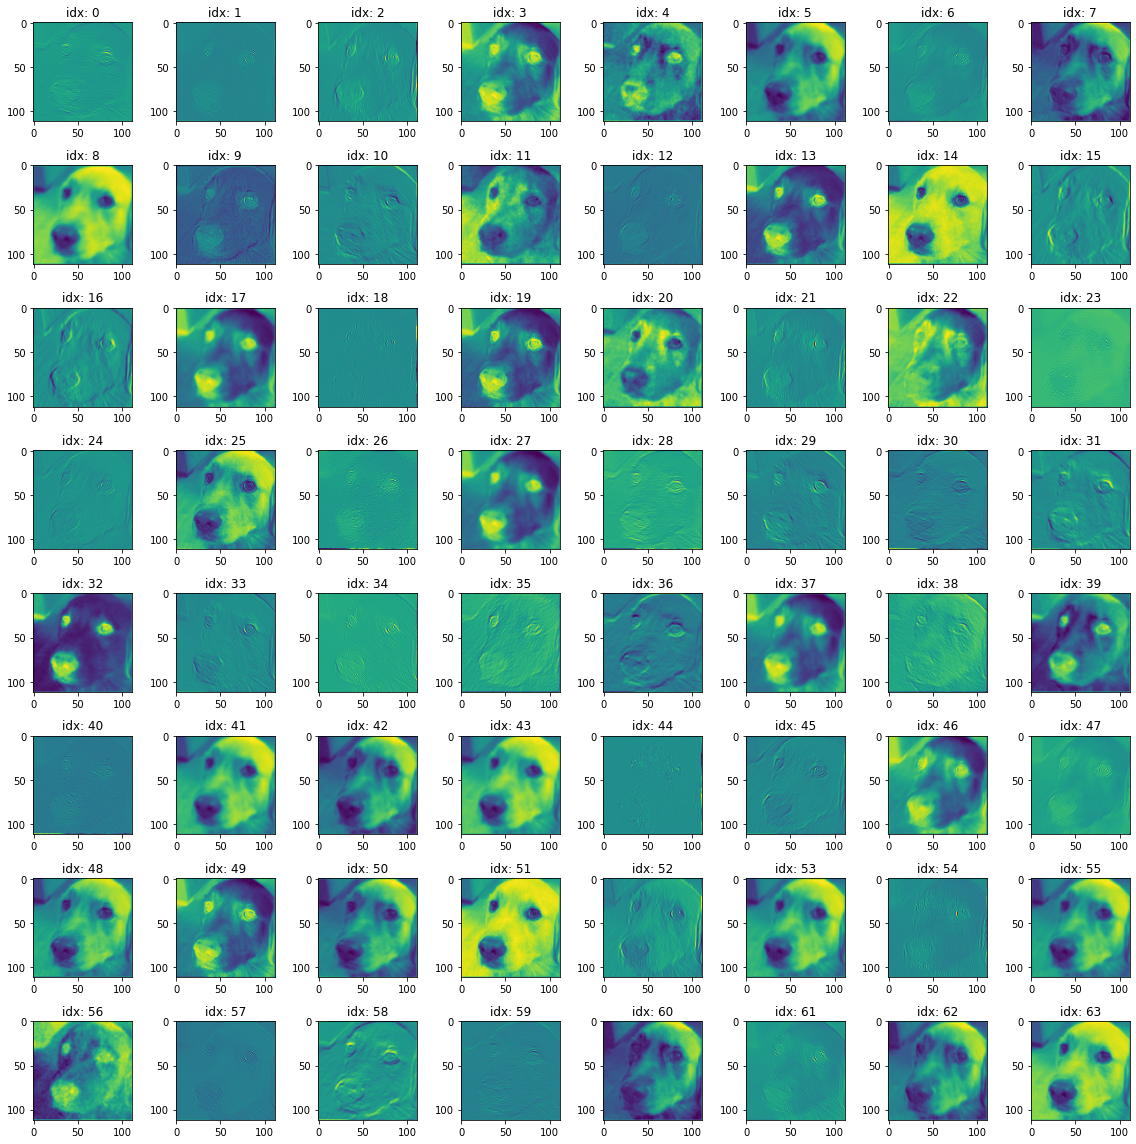

In [85]:
# Feature maps of the first Conv2d layer
# There are 64 filters

layer_number = 0
feature_maps = outputs_from_layer[layer_number].detach().numpy()
figs, axes = plt.subplots(8, 8, figsize=[16,16])
for i in range(feature_maps.shape[1]):
    feature_map = feature_maps[0,i,:,:]
    axes[int(i/8), int(i%8)].set_title('idx: {0}'.format(i))
    axes[int(i/8), int(i%8)].imshow(feature_map)

plt.tight_layout()
figs.show()

Max, idx:  45669.84 20
Min, idx:  -47051.2 39


/var/folders/km/yy6j8xtj559ghwbv692hx3kr0000gn/T/ipykernel_47496/1250781454.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs.show()


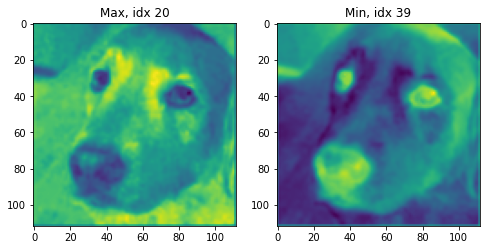

In [86]:
# Find the most active filter in the first Conv2d layer
layer_number = 0
fmaps = outputs_from_layer[layer_number].detach().numpy()

output_from_filters = fmaps.sum(axis=3).sum(axis=2)
idx_max = output_from_filters.argmax()
max = output_from_filters.max()
idx_min = output_from_filters.argmin()
min = output_from_filters.min()

print('Max, idx: ', max, idx_max)
print('Min, idx: ', min, idx_min)

img_max = fmaps[0,idx_max,:,:]
img_min = fmaps[0,idx_min,:,:]

figs, axes = plt.subplots(1,2, figsize=[8,16])
axes[0].set_title('Max, idx {0}'.format(idx_max))
axes[0].imshow(img_max)
axes[1].set_title('Min, idx {0}'.format(idx_min))
axes[1].imshow(img_min)
figs.show()

/var/folders/km/yy6j8xtj559ghwbv692hx3kr0000gn/T/ipykernel_47496/2250005903.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs.show()


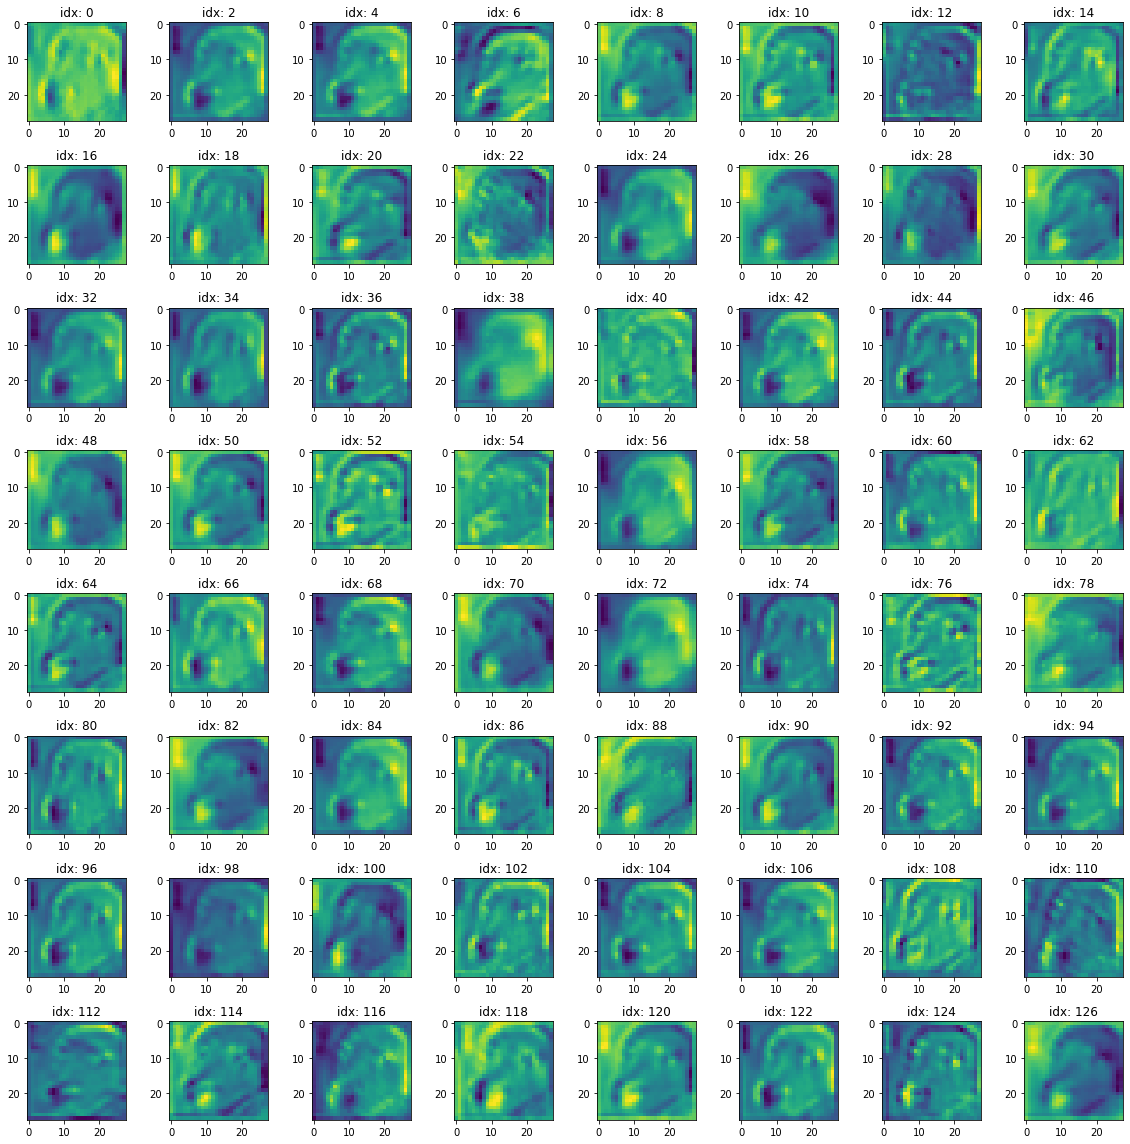

In [87]:
# Feature maps of the 20th Conv2d layer
# Pickup 128 filters

pickup_idx = [2*x for x in range(64)]
layer_number = 20
feature_maps = outputs_from_layer[layer_number].detach().numpy()
figs, axes = plt.subplots(8, 8, figsize=[16,16])
for i in pickup_idx:
    feature_map = feature_maps[0,i,:,:]
    axes[int(i/2/8), int(i/2%8)].set_title('idx: {0}'.format(i))
    axes[int(i/2/8), int(i/2%8)].imshow(feature_map)

plt.tight_layout()
figs.show()

Max, idx:  4.234768 2
Min, idx:  -3.5238733 119


/var/folders/km/yy6j8xtj559ghwbv692hx3kr0000gn/T/ipykernel_47496/769718847.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs.show()


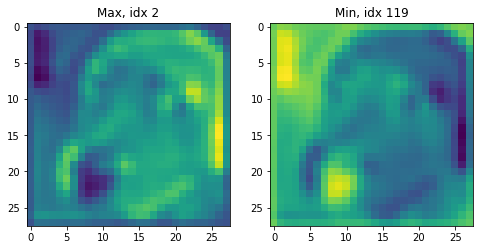

In [88]:
# Find the most active filter in the 20th layer
layer_number = 20
fmaps = outputs_from_layer[layer_number].detach().numpy()

output_from_filters = fmaps.sum(axis=3).sum(axis=2)
idx_max = output_from_filters.argmax()
max = output_from_filters.max()
idx_min = output_from_filters.argmin()
min = output_from_filters.min()

print('Max, idx: ', max, idx_max)
print('Min, idx: ', min, idx_min)

img_max = fmaps[0,idx_max,:,:]
img_min = fmaps[0,idx_min,:,:]

figs, axes = plt.subplots(1,2, figsize=[8,16])
axes[0].set_title('Max, idx {0}'.format(idx_max))
axes[0].imshow(img_max)
axes[1].set_title('Min, idx {0}'.format(idx_min))
axes[1].imshow(img_min)
figs.show()

/var/folders/km/yy6j8xtj559ghwbv692hx3kr0000gn/T/ipykernel_47496/3693787292.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs.show()


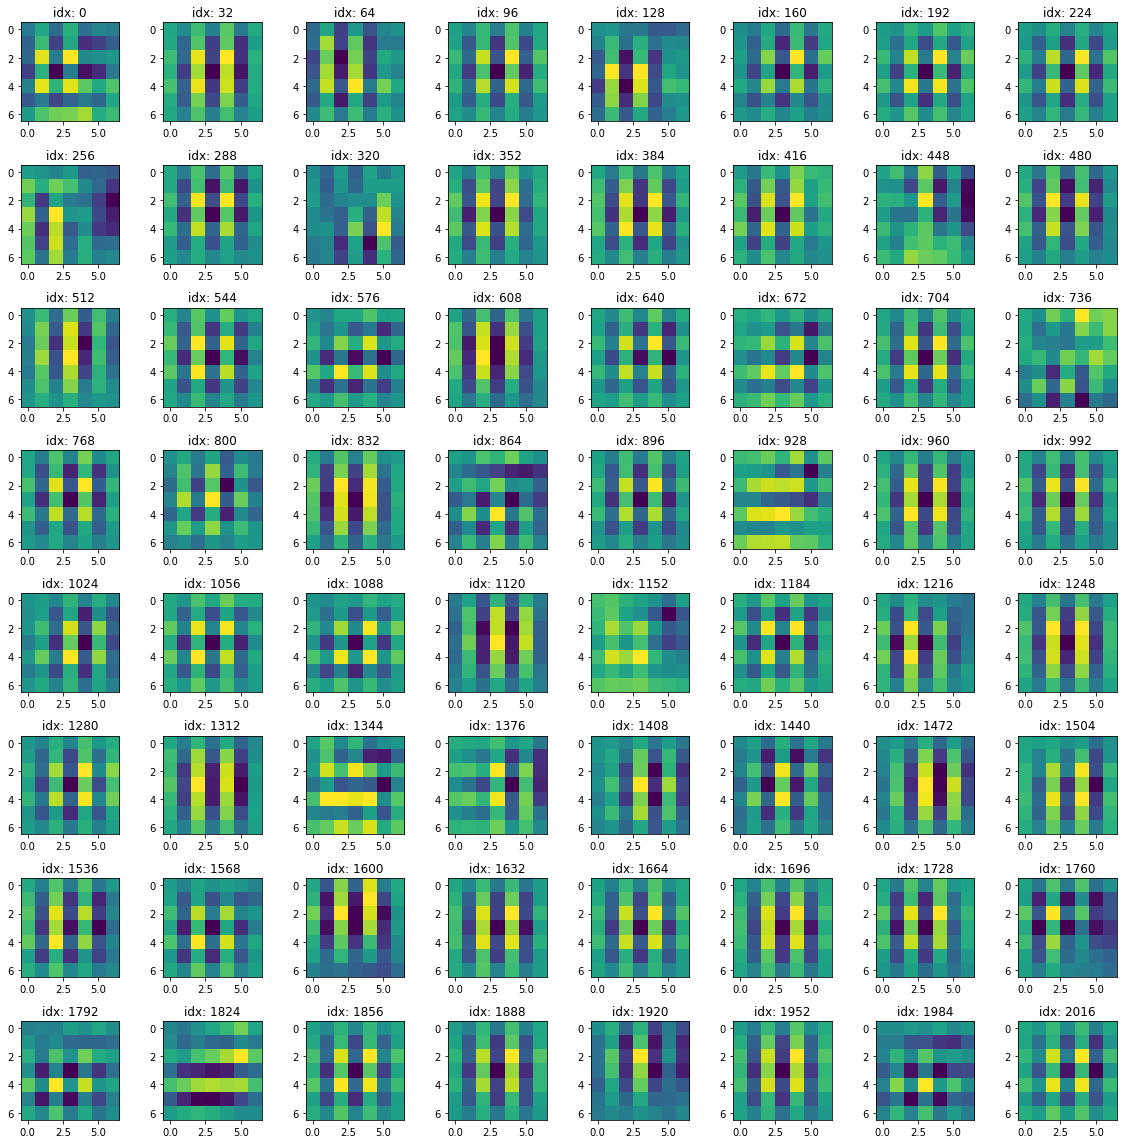

In [89]:
# Feature maps of the last Conv2d layer
# There are 2048 filters

pickup_idx = [32*x for x in range(64)]
layer_number = 100
feature_maps = outputs_from_layer[layer_number].detach().numpy()
figs, axes = plt.subplots(8, 8, figsize=[16,16])
for i in pickup_idx:
    feature_map = feature_maps[0,i,:,:]
    axes[int(i/32/8), int(i/32%8)].set_title('idx: {0}'.format(i))
    axes[int(i/32/8), int(i/32%8)].imshow(feature_map)

plt.tight_layout()
figs.show()

Max, idx:  8.599744e-11 65
Min, idx:  -8.197407e-11 1063


/var/folders/km/yy6j8xtj559ghwbv692hx3kr0000gn/T/ipykernel_47496/3091646809.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs.show()


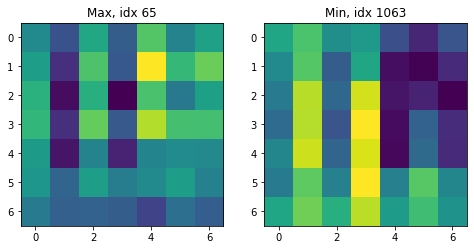

In [90]:
# Find the most active filter in the 100th layer
layer_number = 100
fmaps = outputs_from_layer[layer_number].detach().numpy()

output_from_filters = fmaps.sum(axis=3).sum(axis=2)
idx_max = output_from_filters.argmax()
max = output_from_filters.max()
idx_min = output_from_filters.argmin()
min = output_from_filters.min()

print('Max, idx: ', max, idx_max)
print('Min, idx: ', min, idx_min)

img_max = fmaps[0,idx_max,:,:]
img_min = fmaps[0,idx_min,:,:]

figs, axes = plt.subplots(1,2, figsize=[8,16])
axes[0].set_title('Max, idx {0}'.format(idx_max))
axes[0].imshow(img_max)
axes[1].set_title('Min, idx {0}'.format(idx_min))
axes[1].imshow(img_min)
figs.show()